# Imports

In [3]:
import pandas as pd
import numpy as np
from typing import Tuple
from google.colab import drive

from sklearn.linear_model import LogisticRegression
from google.colab import drive

Mounted at /content/drive


# DataCollector - Do Not Modify

In [ ]:
from sqlalchemy.sql.schema import ScalarElementColumnDefault
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

class DataCollector:

    def artist_styles_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def sources_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def num_inference_steps_one_hot(self):
        raise NotImplementedError(
            "you need to implement this, needs to be two lists, one for string one for coefficient, coefficient list is one larger to account for 'other'"
            "Coefficient is from the model after training, so to prepare training data, you can put dummy number first, then replace it later after model has been trained"
        )

    def one_hot_encoding_functions(self):
        return zip(
            [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
            ['artist_style', 'source', 'num_inference_steps']
        )

    def custom_aggregation(self, prefix, data):
        result = {
            f'{prefix}_likes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == 1)),
            f'{prefix}_dislikes': np.sum((data['engagement_type'] == 'Like') & (data['engagement_value'] == -1)),
            f'{prefix}_engagement_time_avg': data[data['engagement_type'] == 'MillisecondsEngagedWith']['engagement_value'].mean(),
        }
        return pd.Series(result)

    def feature_generation_user(self):
        return self.user_data.groupby('user_id').apply(lambda data: self.custom_aggregation('user', data)).reset_index()

    def feature_generation_content_one_hot_encoding(self):
        for (categories, _coefficient), col_name in self.one_hot_encoding_functions():
            transformed_col = self.generated_content_metadata_data[col_name].apply(lambda x: x if x in categories else 'other').to_frame()
            encoder = OneHotEncoder(categories=[categories + ['other']], sparse=False)
            encoded_data = encoder.fit_transform(transformed_col)
            encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([col_name]))
            for col in encoded_df.columns:
              self.generated_content_metadata_data[col] = encoded_df[col]
        return self.generated_content_metadata_data

    def feature_generation_content_engagement_value(self):
        return self.engagement_data.groupby('content_id').apply(
            lambda data: self.custom_aggregation('content', data)
        ).reset_index()

    def feature_generation(self):
      self.feature_generation_user()
      self.feature_generation_content_one_hot_encoding()
      self.feature_generation_content_engagement_value()

    def get_engagement_data(self, content_ids):
      df = pd.read_csv('sample_data/engagement.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_generated_content_metadata_data(self, content_ids):
      df = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")
      return df[df['content_id'].isin(content_ids)]

    def get_user_data(self, user_id):
      df = pd.read_csv('sample_data/engagement.csv', sep="\t")
      return df[df['user_id'] == user_id]

    def gather_data(self, user_id, content_ids):
      self.engagement_data = self.get_engagement_data(content_ids)
      self.generated_content_metadata_data = self.get_generated_content_metadata_data(content_ids)
      self.user_data = self.get_user_data(user_id)

    def gather_training_data(self):
      self.engagement_data = pd.read_csv('sample_data/engagement.csv', sep="\t")
      self.generated_content_metadata_data = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")
      self.user_data = pd.read_csv('sample_data/engagement.csv', sep="\t")

    def feature_eng_training(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()

      interaction_pairs = self.engagement_data[
          ['user_id', 'content_id']].drop_duplicates()

      self.training_results = pd.merge(
          interaction_pairs,
          user_attr,
          on='user_id',
          how='left'
      ).fillna(0)

      content_results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)

      self.training_results = pd.merge(
          self.training_results,
          content_results,
          on='content_id',
          how='left'
      ).fillna(0)

      return self.training_results

    def feature_eng(self):
      user_attr = self.feature_generation_user()
      content_engagement_features = self.feature_generation_content_engagement_value()
      generated_content_features = self.feature_generation_content_one_hot_encoding()
      self.results = pd.merge(
          generated_content_features,
          content_engagement_features,
          on='content_id',
          how='left'
      ).fillna(0)
      self.results['user_id'] = user_attr['user_id'].iloc[0]
      self.results = pd.merge(
          self.results,
          user_attr,
          on='user_id'
      )

    def threshold(self):
        raise NotImplementedError("you need to implement")

    def coefficients(self):
        return {
            'content_likes': 0.0,
            'content_dislikes': 0.0,
            'content_engagement_time_avg': 0.0,

            'user_likes': 0.0,
            'user_dislikes': 0.0,
            'user_engagement_time_avg': 0.0,
        }

    def get_columns(self):
      cols = list(self.coefficients().keys())
      for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            cols.append(col_name + "_" + str(category))
      return cols

    def run_linear_model(self):
        coeffs = self.coefficients()
        for (categories, _coefficients), col_name in self.one_hot_encoding_functions():
          for category, coefficient in zip(categories + ['other'], _coefficients):
            coeffs[col_name + "_" + str(category)] = coefficient

        self.results['linear_output'] = 0.0
        for col_name, _coefficient in coeffs.items():
            self.results['linear_output'] += self.results[col_name] * _coefficient
        return self.results[self.results['linear_output'] >= self.threshold()]['content_id'].values

    def filter_content_ids(self, user_id, content_ids):
      self.gather_data(user_id, content_ids)
      self.feature_eng()
      return self.run_linear_model()

# Your Implementation - Example Here, Must Modify

In [ ]:
class DataCollectorImplExample(DataCollector):
  def artist_styles_one_hot(self):
    return [
        'anime', 'medieval', 'studio'
    ], [
        0.5, 0.5, 0.5, 0.5
    ]

  def sources_one_hot(self):
    return [
        'human_prompts', 'r/Showerthoughts', 'r/EarthPorn'
    ], [
        0.5, 0.5, 0.5, 0.5
    ]

  def num_inference_steps_one_hot(self):
    return [
        20, 50
    ], [
        0.5, 0.5, 0.5
    ]

  def one_hot_encoding_functions(self):
    return zip(
        [self.artist_styles_one_hot(), self.sources_one_hot(), self.num_inference_steps_one_hot()],
        ['artist_style', 'source', 'num_inference_steps']
    )

  def threshold(self):
    return 300

  def coefficients(self):
        return {
          'content_likes': 104.48448080386746,
          'content_dislikes': -256.82015192805903,
          'content_engagement_time_avg': 8.057773633873186e-07,
          'user_likes': 0.7525136884076168,
          'user_dislikes': -0.1502183573794211,
          'user_engagement_time_avg': 0.00030911703068956127,
          'artist_style_anime': 52.408940915308825,
          'artist_style_medieval': -1.2635383495035055,
          'artist_style_studio': 56.92221997077624,
          'artist_style_other': -108.06762253650498,
          'source_human_prompts': 74.98897024194356,
          'source_r/Showerthoughts': -84.75159543701908,
          'source_r/EarthPorn': 103.55289816316545,
          'source_other': -93.79027296795866,
          'num_inference_steps_20': 5.577317053822645,
          'num_inference_steps_50': 38.993461681648775,
          'num_inference_steps_other': -44.57077873559393,
          'artist_style_anime': 52.40894091531089,
          'artist_style_medieval': -1.2635383494951389,
          'artist_style_studio': 56.92221997077871,
          'artist_style_other': -108.06762253650436,
          'source_human_prompts': 74.98897024194527,
          'source_r/Showerthoughts': -84.75159543701812,
          'source_r/EarthPorn': 103.55289816316679,
          'source_other': -93.79027296819486,
          'num_inference_steps_20': 5.577317053751356,
          'num_inference_steps_50': 38.99346168159167,
          'num_inference_steps_other': -44.57077873559456,
}

# Example For Use In Production

In [ ]:
data_collector = DataCollectorImplExample()
random_content_ids = pd.read_csv('sample_data/generated_content_metadata.csv', sep="\t")['content_id'].values
data_collector.filter_content_ids(1, random_content_ids)

# Training

In [ ]:
#@title get training data
data_collector = DataCollectorImplExample()
data_collector.gather_training_data()
training_data = data_collector.feature_eng_training()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
training_data

,user_id,content_id,user_likes,user_dislikes,user_engagement_time_avg,guidance_scale,num_inference_steps,artist_style,source,artist_style_anime,...,source_human_prompts,source_r/Showerthoughts,source_r/EarthPorn,source_other,num_inference_steps_20,num_inference_steps_50,num_inference_steps_other,content_likes,content_dislikes,content_engagement_time_avg
0,1,38318,11.0,2.0,10456.6250,10,75,movie: I-am-Sam,I-am-Sam,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1950.000000
1,1,74487,11.0,2.0,10456.6250,4,75,movie: Se7en,Se7en,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3411.000000
2,1,78133,11.0,2.0,10456.6250,4,75,movie: Priest,Priest,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3453.000000
3,1,80916,11.0,2.0,10456.6250,4,75,juan_gris,r/Showerthoughts,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,2528.555556
4,1,89403,11.0,2.0,10456.6250,7,75,0,human_prompts,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1898.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161523,82,106258,169.0,113.0,4009.6132,7,75,0,human_prompts,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,19.0,2.0,2384.466667
161524,82,106635,169.0,113.0,4009.6132,12,75,0,human_prompts,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,1.0,4497.717949
161525,82,117229,169.0,113.0,4009.6132,10,20,marta_minujín,r/scifi,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,10.0,12.0,3556.772727
161526,82,120143,169.0,113.0,4009.6132,3,20,anime,r/scifi,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,16.0,3.0,2892.115385


In [ ]:
#@title code to implement
def get_Y(engagement_data: pd.DataFrame) -> pd.DataFrame:
    """Engineers taget variable.
    Args
      data (pd.DataFrame): Engagement data.
    Returns
      pd.DataFrame: Dataframe of 3 columns; 'user_id', 'content_id', 'score',
        where 'score' being the target variable that you want to predict.
    """
    # Dummy target dataframe. Your output dataframe should have 3 columns; 'user_id', 'content_id', 'score'
    # Where 'score' being the target variable that you want to predict.

    like_dislike  = engagement_data[engagement_data['engagement_type'] == 'Like'].copy()
    like_dislike.drop_duplicates(inplace = True)
    target_df1 = like_dislike.groupby(
        ['user_id', 'content_id']
        )['engagement_value'].sum().rename('score1',
                                           inplace=True
                                           ).to_frame().reset_index()
    target_df1.fillna(-0.5)
    target_df2 = engagement_data.groupby(
        ['user_id', 'content_id']
        )['engagement_value'].sum().rename('score2',
                                           inplace=True
                                           ).to_frame().reset_index()
    target_df = pd.merge(
          target_df2,
          target_df1,
          on=['user_id', 'content_id'],
          how='left'
      )
    target_df['score1'].fillna(-0.5,inplace = True)
    target_df['score'] = target_df.apply(lambda row: row['score1'] * (row['score2'] if row['score2'] < 5000 else 5000), axis=1)
    display(target_df)

    # DO NOT CHANGE THIS. This step ensures that each row of the target variable (X)
    # corresponds to the correct row of features (y).
    target_df = pd.merge(
          training_data[['user_id', 'content_id']],
          target_df,
          on=['user_id', 'content_id'],
          how='left'
      )

    return target_df['score'].fillna(0)

engagement_data = pd.read_csv('sample_data/engagement.csv', sep="\t")
X = training_data[data_collector.get_columns()]
y = get_Y(engagement_data)

['content_likes', 'content_dislikes', 'content_engagement_time_avg', 'user_likes', 'user_dislikes', 'user_engagement_time_avg', 'artist_style_anime', 'artist_style_medieval', 'artist_style_studio', 'artist_style_other', 'source_human_prompts', 'source_r/Showerthoughts', 'source_r/EarthPorn', 'source_other', 'num_inference_steps_20', 'num_inference_steps_50', 'num_inference_steps_other']


,user_id,content_id,score2,score1,score
0,1,28671,1350,-0.5,-675.0
1,1,28731,281,-0.5,-140.5
2,1,28734,9120,-0.5,-2500.0
3,1,28785,1700,-0.5,-850.0
4,1,28862,1762,-0.5,-881.0
...,...,...,...,...,...
161523,115,70943,767,-0.5,-383.5
161524,115,74471,500,-0.5,-250.0
161525,115,82049,2833,-0.5,-1416.5
161526,116,29923,400,-0.5,-200.0


In [ ]:
# training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Split data into train and test: Add/change  other parametersas you wish
# Also, feel free to use cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Depending on what your target variable y looks like, you have to choose a suitable model.
# Here, I assume y is binary, and so I use Logistic Regression.
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

print(f"MSE: {np.mean((y_pred - y_test)**2)}")

MSE: 4111634.6787969945


In [ ]:
# cutoff selection: evaluate the f1 score of Like engagement type on the test set
# We run this multiple times and take the average f1 scores. Based on the search and the required number of filtered contents, we finally pick 300 as the threshold.
all_f1s = {}
for thres in range(-5000,5000,200):
  y_test_binary_pred = (y_pred > thres).astype(int)
  like_dislike  = engagement_data[engagement_data['engagement_type'] == 'Like'].copy()
  like_dislike = like_dislike.groupby(['user_id', 'content_id'])['engagement_value'].max().rename('score1',
                                            inplace=True
                                            ).to_frame().reset_index()
  df = training_data.loc[y_test.index,:]
  target_df = pd.merge(
            df[['user_id', 'content_id']],
            like_dislike,
            on=['user_id', 'content_id'],
            how='left'
        )
  target_df['is_filtered'] = y_test_binary_pred
  target_df = target_df[~target_df['score1'].isna()]

  from sklearn.metrics import f1_score
  all_f1s[thres] = f1_score((target_df['score1']+1)//2,target_df['is_filtered'])

In [ ]:
all_f1s

{-5000: 0.72069602906495,
 -4800: 0.7207649402390439,
 -4600: 0.7208160663053873,
 -4400: 0.7207982657485336,
 -4200: 0.720803443328551,
 -4000: 0.7209183673469388,
 -3800: 0.7209413565483593,
 -3600: 0.7209695423377452,
 -3400: 0.7209695423377452,
 -3200: 0.7210207336523127,
 -3000: 0.7210541428708165,
 -2800: 0.7210801838610827,
 -2600: 0.7215230307289336,
 -2400: 0.722444408894577,
 -2200: 0.723265201512142,
 -2000: 0.7249887553813532,
 -1800: 0.7271437324647683,
 -1600: 0.7310913458417192,
 -1400: 0.7361561384549891,
 -1200: 0.7472637479978644,
 -1000: 0.7691614379311539,
 -800: 0.8059059207597566,
 -600: 0.8287107345535929,
 -400: 0.8256687310581103,
 -200: 0.7750824762274403,
 0: 0.6910700788251808,
 200: 0.578085792806787,
 400: 0.49031927170150025,
 600: 0.4216157648811539,
 800: 0.3688063063063063,
 1000: 0.3263543191800879,
 1200: 0.2768695125643354,
 1400: 0.21532416502946955,
 1600: 0.15906508683655252,
 1800: 0.11291531351486385,
 2000: 0.08344617467840217,
 2200: 0.057172

# What You Need

In [ ]:
print("{")
for x, y in zip(model.feature_names_in_, model.coef_):
  print(f"\t'{x}': {y},")
print("}")

{
	'content_likes': 104.48448080386746,
	'content_dislikes': -256.82015192805903,
	'content_engagement_time_avg': 8.057773633873186e-07,
	'user_likes': 0.7525136884076168,
	'user_dislikes': -0.1502183573794211,
	'user_engagement_time_avg': 0.00030911703068956127,
	'artist_style_anime': 52.408940915308825,
	'artist_style_medieval': -1.2635383495035055,
	'artist_style_studio': 56.92221997077624,
	'artist_style_other': -108.06762253650498,
	'source_human_prompts': 74.98897024194356,
	'source_r/Showerthoughts': -84.75159543701908,
	'source_r/EarthPorn': 103.55289816316545,
	'source_other': -93.79027296795866,
	'num_inference_steps_20': 5.577317053822645,
	'num_inference_steps_50': 38.993461681648775,
	'num_inference_steps_other': -44.57077873559393,
	'artist_style_anime': 52.40894091531089,
	'artist_style_medieval': -1.2635383494951389,
	'artist_style_studio': 56.92221997077871,
	'artist_style_other': -108.06762253650436,
	'source_human_prompts': 74.98897024194527,
	'source_r/Showerthought

# Policy Filtering 1

In [ ]:
def policy_filter_one(training_data, content_ids):
  df = training_data[training_data['content_id'].isin(content_ids)]
  all_content_ids = df['content_id']
  df_human = df[df['source'] == 'human_prompts']
  sorted_human_content = df_human.sort_values('content_dislikes', ascending=False)
  # Remove duplicates
  sorted_human_content = sorted_human_content.drop_duplicates(subset=['content_id'])
  bottom_60_percent_cutoff = int(len(sorted_human_content) * 0.75)
  bottom_content_ids = sorted_human_content.iloc[:bottom_60_percent_cutoff]['content_id']
  lst = list(set(all_content_ids) - set(bottom_content_ids))
  return lst

# policy_filter_one(
#     training_data[training_data['content_id'] == random_content_ids[0]],
#     random_content_ids[0]
# )

# Policy Filtering 2

In [ ]:
def policy_filter_two(training_data, content_ids):
    df = training_data[training_data['content_id'].isin(content_ids)]
    all_content_ids = df['content_id']
    df_movie = df.dropna(subset=['artist_style'])
    df_movie = df_movie[df_movie['artist_style'].apply(lambda x: 'movie' in str(x).lower())]
    sorted_movie_content = df_movie.sort_values('content_dislikes', ascending=False)
    # Remove duplicates
    sorted_movie_content = sorted_movie_content.drop_duplicates(subset=['content_id'])
    bottom_60_percent_cutoff = int(len(sorted_movie_content) * 0.750)
    bottom_content_ids = sorted_movie_content.iloc[:bottom_60_percent_cutoff]['content_id']
    lst = list(set(all_content_ids) - set(bottom_content_ids))
    return lst


# policy_filter_two(
#     training_data[training_data['content_id'] == random_content_ids[0]],
#     random_content_ids[0]
# )

# some EDA

In [ ]:
engagement = pd.read_csv("sample_data/engagement.csv",sep ='\t')
metadata = pd.read_csv("sample_data/generated_content_metadata.csv",sep = '\t')

In [ ]:
display(engagement.head())
display(metadata.head())

,content_id,user_id,engagement_type,engagement_value,engagement_metadata
0,38318,1,MillisecondsEngagedWith,2750,NaN
1,74487,1,MillisecondsEngagedWith,2150,NaN
2,78133,1,MillisecondsEngagedWith,3684,NaN
3,80916,1,MillisecondsEngagedWith,3784,NaN
4,89403,1,MillisecondsEngagedWith,2000,NaN


,content_id,guidance_scale,num_inference_steps,artist_style,source
0,28598,8,75,movie: Prestige-The,Prestige-The
1,28599,7,75,movie: Prestige-The,Prestige-The
2,28600,9,75,movie: Prestige-The,Prestige-The
3,28601,8,75,movie: Prestige-The,Prestige-The
4,28602,8,75,movie: Prestige-The,Prestige-The


In [ ]:
def like_vs_dislike(col):
  top_artist_styles = metadata[col].value_counts()[:10].index
  temp = metadata[metadata[col].isin(top_artist_styles)].copy()
  temp = pd.merge(
            engagement[['content_id','engagement_type','engagement_value']],
            temp[['content_id',col]],
            on=['content_id'],
            how='left'
        )
  temp = temp[temp['engagement_type']=='Like']
  return temp.groupby(col)['engagement_value'].value_counts()

In [ ]:
like_vs_dislike('artist_style')

artist_style          engagement_value
anime                  1                  1025
                      -1                   187
detailed_portrait      1                   539
                      -1                   297
edward_hopper          1                   622
                      -1                   252
jean-michel_basquiat   1                   364
                      -1                   287
kerry_james_marshall   1                   373
                      -1                   263
leonardo_da_vinci      1                   338
                      -1                   294
medieval               1                  1458
                      -1                   303
studio                 1                   834
                      -1                   184
takashi_murakami       1                   344
                      -1                   251
van_gogh               1                   500
                      -1                   258
Name: engagement_valu

In [ ]:
like_vs_dislike('source')

source                  engagement_value
human_prompts            1                  18304
                        -1                   7289
r/AccidentalArt          1                    197
                        -1                    125
r/Damnthatsinteresting   1                    359
                        -1                    343
r/EarthPorn              1                   3745
                        -1                    559
r/MadeMeSmile           -1                    338
                         1                    296
r/Showerthoughts         1                   2113
                        -1                   1300
r/SimplePrompts          1                    319
                        -1                    227
r/educationalgifs        1                    382
                        -1                    224
r/pics                   1                    556
                        -1                    440
r/scifi                  1                    763
         

In [ ]:
like_vs_dislike('num_inference_steps')

num_inference_steps  engagement_value
20                    1                   6708
                     -1                   3671
50                    1                   4309
                     -1                   2083
75                    1                  32033
                     -1                  29006
100                   1                   1649
                     -1                    749
Name: engagement_value, dtype: int64

,content_id,user_id,engagement_type,engagement_value_x,engagement_value_y
1,97896,4,Like,1,1472.0
2,127102,4,Like,1,1452.0
3,74140,4,Like,1,1851.0
4,90184,4,Like,1,2402.0
6,29319,5,Like,1,2684.0


,content_id,user_id,engagement_type,engagement_value_x,engagement_value_y
0,49861,4,Like,-1,1444.0
2,38871,5,Like,-1,3017.0
4,53952,5,Like,-1,3571.0
7,57834,5,Like,-1,3899.0
9,82909,5,Like,-1,12999.0


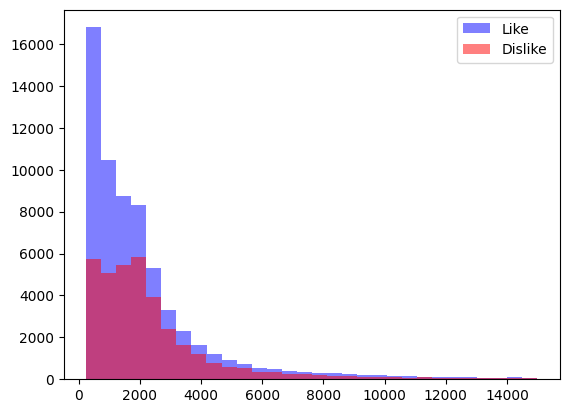

In [ ]:
like_dislike = engagement[engagement['engagement_type'] == 'Like'].copy()
like = pd.merge(
            like_dislike[like_dislike['engagement_value']==1][['content_id','user_id','engagement_type','engagement_value']],
            engagement[engagement['engagement_type'] == 'MillisecondsEngagedWith'][['content_id','user_id','engagement_value']],
            on=['content_id','user_id'],
            how='left'
        )
dislike = pd.merge(
            like_dislike[like_dislike['engagement_value']==-1][['content_id','user_id','engagement_type','engagement_value']],
            engagement[engagement['engagement_type'] == 'MillisecondsEngagedWith'][['content_id','user_id','engagement_value']],
            on=['content_id','user_id'],
            how='left'
        )
like = like[like['engagement_value_y']<15000].dropna()
display(like.head())
dislike = dislike[dislike['engagement_value_y']<15000].dropna()
display(dislike.head())

import matplotlib.pyplot as plt

plt.hist(like['engagement_value_y'], bins=30, alpha=0.5, color='blue', label='Like')
plt.hist(dislike['engagement_value_y'], bins=30, alpha=0.5, color='red', label='Dislike')
plt.legend()
plt.show()

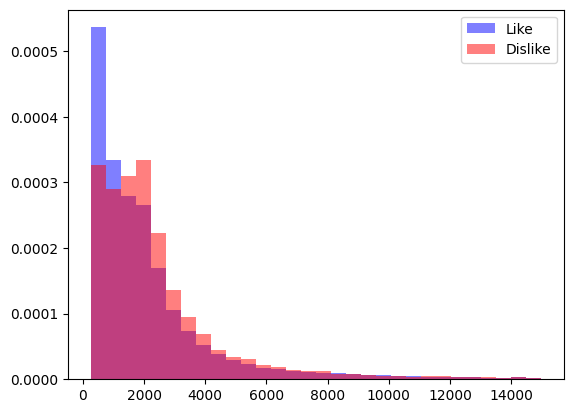

In [ ]:
plt.hist(like['engagement_value_y'], bins=30, alpha=0.5, color='blue', label='Like', density=True)
plt.hist(dislike['engagement_value_y'], bins=30, alpha=0.5, color='red', label='Dislike', density=True)
plt.legend()
plt.show()

## Data Exploration

1. Size of Engagement is 293738 * 5

2. Size of Metadata is 107705 * 5

In [6]:
engagement = pd.read_csv("sample_data/engagement.csv",sep ='\t')
metadata = pd.read_csv("sample_data/generated_content_metadata.csv",sep = '\t')

In [7]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293738 entries, 0 to 293737
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   content_id           293738 non-null  int64 
 1   user_id              293738 non-null  int64 
 2   engagement_type      293738 non-null  object
 3   engagement_value     293738 non-null  int64 
 4   engagement_metadata  167911 non-null  object
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107705 entries, 0 to 107704
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   content_id           107705 non-null  int64 
 1   guidance_scale       107705 non-null  int64 
 2   num_inference_steps  107705 non-null  int64 
 3   artist_style         76612 non-null   object
 4   source               107705 non-null  object
dtypes: int64(3), object(2)
memory usage: 4.1+ MB


## Engagement Analysis

1. There are 57162 unique content_ids in Engagement

2. There are 110 unique user_ids in Engagement.

3. There are two types of engagement_type a) MillisecondsEngagedWith (213530) b) Like (80208)

4. 38979 unique content_ids have been liked or disliked. 44699 out of 80208 (55.7%) are likes and 44.3% are dislikes.

5. 54228 unique content_ids have been milliseconds engaged_with -> some users hit like/dislike, while other users did not make an action.

6. Mean of engagement_value for content_ids has been disliked is 1751. After 6% outliers removed.

7. Mean of engagement_value for content_ids has been liked is 1696. After 6% outliers removed. See code output for details -> mean, std, 25%, 75%, min, max

7. Engagement_metadata shows which controller generated this piece of cotent -> 21863 out of 167911 are generated by ECHO.

In [9]:
engagement.content_id.nunique()

57162

In [10]:
engagement.user_id.nunique()

110

In [11]:
engagement.engagement_type.value_counts()

MillisecondsEngagedWith    213530
Like                        80208
Name: engagement_type, dtype: int64

In [12]:
engagement[engagement['engagement_type'] == 'Like'].content_id.nunique()

38979

In [13]:
engagement[engagement['engagement_type'] == 'Like'].engagement_value.value_counts()

 1    44699
-1    35509
Name: engagement_value, dtype: int64

In [14]:
engagement[engagement['engagement_type'] == 'MillisecondsEngagedWith'].content_id.nunique()

54228

In [15]:
liked_id = engagement[engagement['engagement_value'] == 1].content_id.unique()
liked_content = engagement[engagement['content_id'].isin(liked_id)]
no_action_1 = liked_content[liked_content['engagement_type'] == 'MillisecondsEngagedWith']
no_action_1.describe()['engagement_value']

count    1.443820e+05
mean     3.769861e+04
std      2.643709e+06
min      2.510000e+02
25%      6.920000e+02
50%      1.305000e+03
75%      2.523000e+03
max      5.136718e+08
Name: engagement_value, dtype: float64

In [16]:
upper_bound_1 = 2.523000e+03 + 3 * (2.523000e+03 - 6.920000e+02)
lower_bound_1 = 2.510000e+02 - 3 * (2.523000e+03 - 6.920000e+02)

In [17]:
no_action_1[no_action_1['engagement_value'] >= upper_bound_1]

,content_id,user_id,engagement_type,engagement_value,engagement_metadata
35,97499,4,MillisecondsEngagedWith,15102,NaN
48,29319,5,MillisecondsEngagedWith,85452,NaN
54,40323,5,MillisecondsEngagedWith,42035,NaN
56,53952,5,MillisecondsEngagedWith,20549,NaN
58,54002,5,MillisecondsEngagedWith,20999,NaN
...,...,...,...,...,...
293455,86827,82,MillisecondsEngagedWith,8714,"{""controller"": ""CHARLIE""}"
293635,82689,82,MillisecondsEngagedWith,18734,"{""controller"": ""DELTA""}"
293707,91404,82,MillisecondsEngagedWith,28383,"{""controller"": ""DELTA""}"
293709,92468,82,MillisecondsEngagedWith,13281,"{""controller"": ""DELTA""}"


In [18]:
8864/1.443820e+05

0.061392694380185894

In [19]:
disliked_id = engagement[engagement['engagement_value'] == -1].content_id.unique()
disliked_content = engagement[engagement['content_id'].isin(disliked_id)]
no_action_2 = disliked_content[disliked_content['engagement_type'] == 'MillisecondsEngagedWith']
no_action_2.describe()['engagement_value']

count    1.427510e+05
mean     3.871498e+04
std      2.377738e+06
min      2.510000e+02
25%      7.170000e+02
50%      1.382000e+03
75%      2.582000e+03
max      5.136718e+08
Name: engagement_value, dtype: float64

In [20]:
upper_bound_2 = 2.582000e+03 + 3 * (2.582000e+03 - 7.170000e+02)
lower_bound_2 = 7.170000e+02 - 3 * (2.582000e+03 - 7.170000e+02)

In [21]:
no_action_2[no_action_2['engagement_value'] >= upper_bound_2]

,content_id,user_id,engagement_type,engagement_value,engagement_metadata
20,42745,1,MillisecondsEngagedWith,8833,NaN
35,97499,4,MillisecondsEngagedWith,15102,NaN
48,29319,5,MillisecondsEngagedWith,85452,NaN
49,38871,5,MillisecondsEngagedWith,122598,NaN
54,40323,5,MillisecondsEngagedWith,42035,NaN
...,...,...,...,...,...
293455,86827,82,MillisecondsEngagedWith,8714,"{""controller"": ""CHARLIE""}"
293635,82689,82,MillisecondsEngagedWith,18734,"{""controller"": ""DELTA""}"
293707,91404,82,MillisecondsEngagedWith,28383,"{""controller"": ""DELTA""}"
293709,92468,82,MillisecondsEngagedWith,13281,"{""controller"": ""DELTA""}"


In [22]:
8634/1.427510e+05

0.06048293882354589

### Details for 6, 7, 8


In [23]:
no_action_1 = no_action_1[no_action_1['engagement_value'] <= upper_bound_1]
no_action_1.describe()['engagement_value']

count    135521.000000
mean       1696.346913
std        1442.152968
min         251.000000
25%         667.000000
50%        1185.000000
75%        2200.000000
max        8016.000000
Name: engagement_value, dtype: float64

<Axes: >

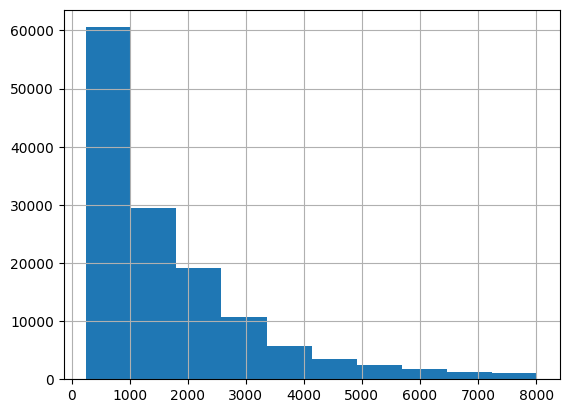

In [24]:
no_action_1['engagement_value'].hist()

In [25]:
no_action_2 = no_action_2[no_action_2['engagement_value'] <= upper_bound_2]
no_action_2.describe()['engagement_value']

count    134119.000000
mean       1751.223861
std        1472.444925
min         251.000000
25%         699.000000
50%        1266.000000
75%        2268.000000
max        8177.000000
Name: engagement_value, dtype: float64

<Axes: >

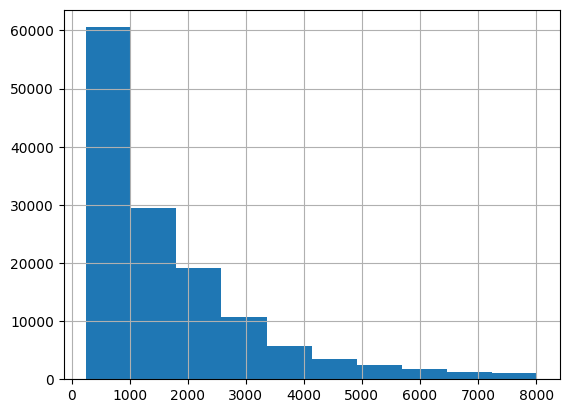

In [26]:
no_action_1['engagement_value'].hist()

In [27]:
engagement['engagement_metadata'].value_counts()

{"controller": "EXAMPLE"}    24012
{"controller": "BETA"}       23494
{"controller": "ECHO"}       21863
{"controller": "FOXTROT"}    21792
{"controller": "DELTA"}      20908
{"controller": "RANDOM"}     20548
{"controller": "CHARLIE"}    18818
{"controller": "ALPHA"}      12048
{"controller": "GOLF"}        4418
{"controller": null}             9
{"controller": "STATIC"}         1
Name: engagement_metadata, dtype: int64

## Metadata Analysis

1. All 107705 content_id in metadata is unique.

2. guidance_scale and num_inference_steps are not analyzed.

3. There are 31093 missing values in artist_style, 26179 out 31093 (84%) are human_prompts after checking sources. Change these missing values to human_prompts.

4. There are a lot of small categories (>1000) in artist_style, follows the format: movie: {movie_name}. Change these categories to a new big category called movie. For details of each category, please see code_below.

5. Reduced to 29 categories for artist_style, with movie, human_prompts, None as top three categories.

6. For sources, there are even more categories than artist_style. Therefore, we would like to first focus on new defined artist_style in later analysis.


In [28]:
metadata['content_id'].nunique()

107705

In [29]:
pd.set_option('display.max_rows', None)

In [30]:
metadata['artist_style'].value_counts()

van_gogh                                                                1097
jean-michel_basquiat                                                    1083
detailed_portrait                                                       1073
kerry_james_marshall                                                    1042
medieval                                                                1040
studio                                                                  1019
edward_hopper                                                           1008
takashi_murakami                                                        1001
anime                                                                    998
leonardo_da_vinci                                                        995
laura_wheeler_waring                                                     993
ma_jir_bo                                                                987
jackson_pollock                                                          985

In [31]:
print(len(metadata[metadata['source'] == 'human_prompts']['artist_style']))
print(len(metadata[metadata['artist_style'].isna()]))

26179
31093


In [32]:
metadata_new = metadata.copy()

In [33]:
# Define the condition
condition = metadata_new['source'] == 'human_prompts'

# Set the new values for 'artist_style' where the condition is True
metadata_new.loc[condition, 'artist_style'] = 'human_prompts'

In [34]:
metadata_new['artist_style'].value_counts()

human_prompts                                                           26179
van_gogh                                                                 1097
jean-michel_basquiat                                                     1083
detailed_portrait                                                        1073
kerry_james_marshall                                                     1042
medieval                                                                 1040
studio                                                                   1019
edward_hopper                                                            1008
takashi_murakami                                                         1001
anime                                                                     998
leonardo_da_vinci                                                         995
laura_wheeler_waring                                                      993
ma_jir_bo                                                       

In [35]:
metadata_new['artist_style'] = metadata_new['artist_style'].fillna('None')

In [36]:
def process_artist_style(x):
  if 'movie' in x:
    return 'movie'
  else:
    return x

In [37]:
metadata_new['new_artist_style'] = metadata_new['artist_style'].apply(process_artist_style)

In [38]:
metadata_new['new_artist_style'].value_counts()

movie                   51056
human_prompts           26179
None                     4914
van_gogh                 1097
jean-michel_basquiat     1083
detailed_portrait        1073
kerry_james_marshall     1042
medieval                 1040
studio                   1019
edward_hopper            1008
takashi_murakami         1001
anime                     998
leonardo_da_vinci         995
laura_wheeler_waring      993
ma_jir_bo                 987
jackson_pollock           985
shepard_fairey            973
unreal_engine             968
face_and_lighting         963
keith_haring              962
marta_minujín             960
franck_slama              960
oil_on_canvas             953
scifi                     947
gta_v                     928
louise bourgeois          924
salvador_dali             914
ibrahim_el_salahi         894
juan_gris                 889
Name: new_artist_style, dtype: int64

## Merged data analysis

Metadata is merged with engagement to further analyze how each artist_style perform.

1.

In [39]:
merged = pd.merge(engagement, metadata_new[['content_id','new_artist_style']], on='content_id', how='left')

In [40]:
pd.set_option('display.max_rows', 30)

In [41]:
with_action = merged[merged['engagement_type'] == 'Like']

In [42]:
result_df = with_action.groupby('new_artist_style')['engagement_value'].value_counts().unstack(fill_value=0)

In [43]:
result_df['Percentage of Like'] = result_df[1]/ (result_df[-1] + result_df[1])
result_df.sort_values('Percentage of Like')

engagement_value,-1,1,Percentage of Like
new_artist_style,,,
movie,20151,11317,0.359635
louise bourgeois,248,282,0.532075
leonardo_da_vinci,294,338,0.534810
None,1145,1336,0.538493
face_and_lighting,300,359,0.544765
franck_slama,293,360,0.551302
jackson_pollock,342,421,0.551769
jean-michel_basquiat,287,364,0.559140
laura_wheeler_waring,275,362,0.568289


In [44]:
merged_ECHO = merged[merged['engagement_metadata'] == '{"controller": "ECHO"}']

In [45]:
with_action_ECHO = merged_ECHO[merged_ECHO['engagement_type'] == 'Like']

In [46]:
merged_ECHO.new_artist_style.value_counts()

movie                   10317
human_prompts            5900
None                      682
medieval                  362
keith_haring              264
anime                     254
unreal_engine             224
shepard_fairey            216
franck_slama              210
edward_hopper             203
leonardo_da_vinci         198
oil_on_canvas             197
ma_jir_bo                 192
laura_wheeler_waring      184
studio                    178
face_and_lighting         176
jean-michel_basquiat      174
juan_gris                 173
marta_minujín             172
louise bourgeois          170
jackson_pollock           167
salvador_dali             165
scifi                     163
van_gogh                  163
detailed_portrait         159
ibrahim_el_salahi         155
takashi_murakami          154
gta_v                     148
kerry_james_marshall      143
Name: new_artist_style, dtype: int64